# Homework Assignment 4 - Chem 277B
## Diabetes Prediction

### 1) Objective

Analyze the Diabetes dataset using linear regression techniques to predict disease progression based on various health metrics.

### 2) Preparation

Before starting, import the necessary libraries for data analysis and visualization. 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import probplot

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

from statsmodels.api import add_constant, OLS, Logit, GLM, families, stats

Load the dataset from `sklearn`, which contains various health metrics and a target variable indicating disease progression.

In [46]:
data, target = load_diabetes(return_X_y=True, as_frame=True, scaled=True) # note: scaled=True did not work as expected!!!
feature_names = ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
data.columns = feature_names

Split the dataset into training (80%) and testing (20%) sets this time. Use `random_state=42` for reproducibility. The dataset is already scaled.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

print(f'Shape of training features: {X_train.shape}')
print(f'Shape of training labels: {y_train.shape}')
print(f'Shape of test features: {X_test.shape}')
print(f'Shape of test labels: {y_test.shape}')

Shape of training features: (353, 10)
Shape of training labels: (353,)
Shape of test features: (89, 10)
Shape of test labels: (89,)


### 3) Visualization

Visualize the dataset using pair plots to understand the relationships between features. Discuss any patterns or correlations you observe.

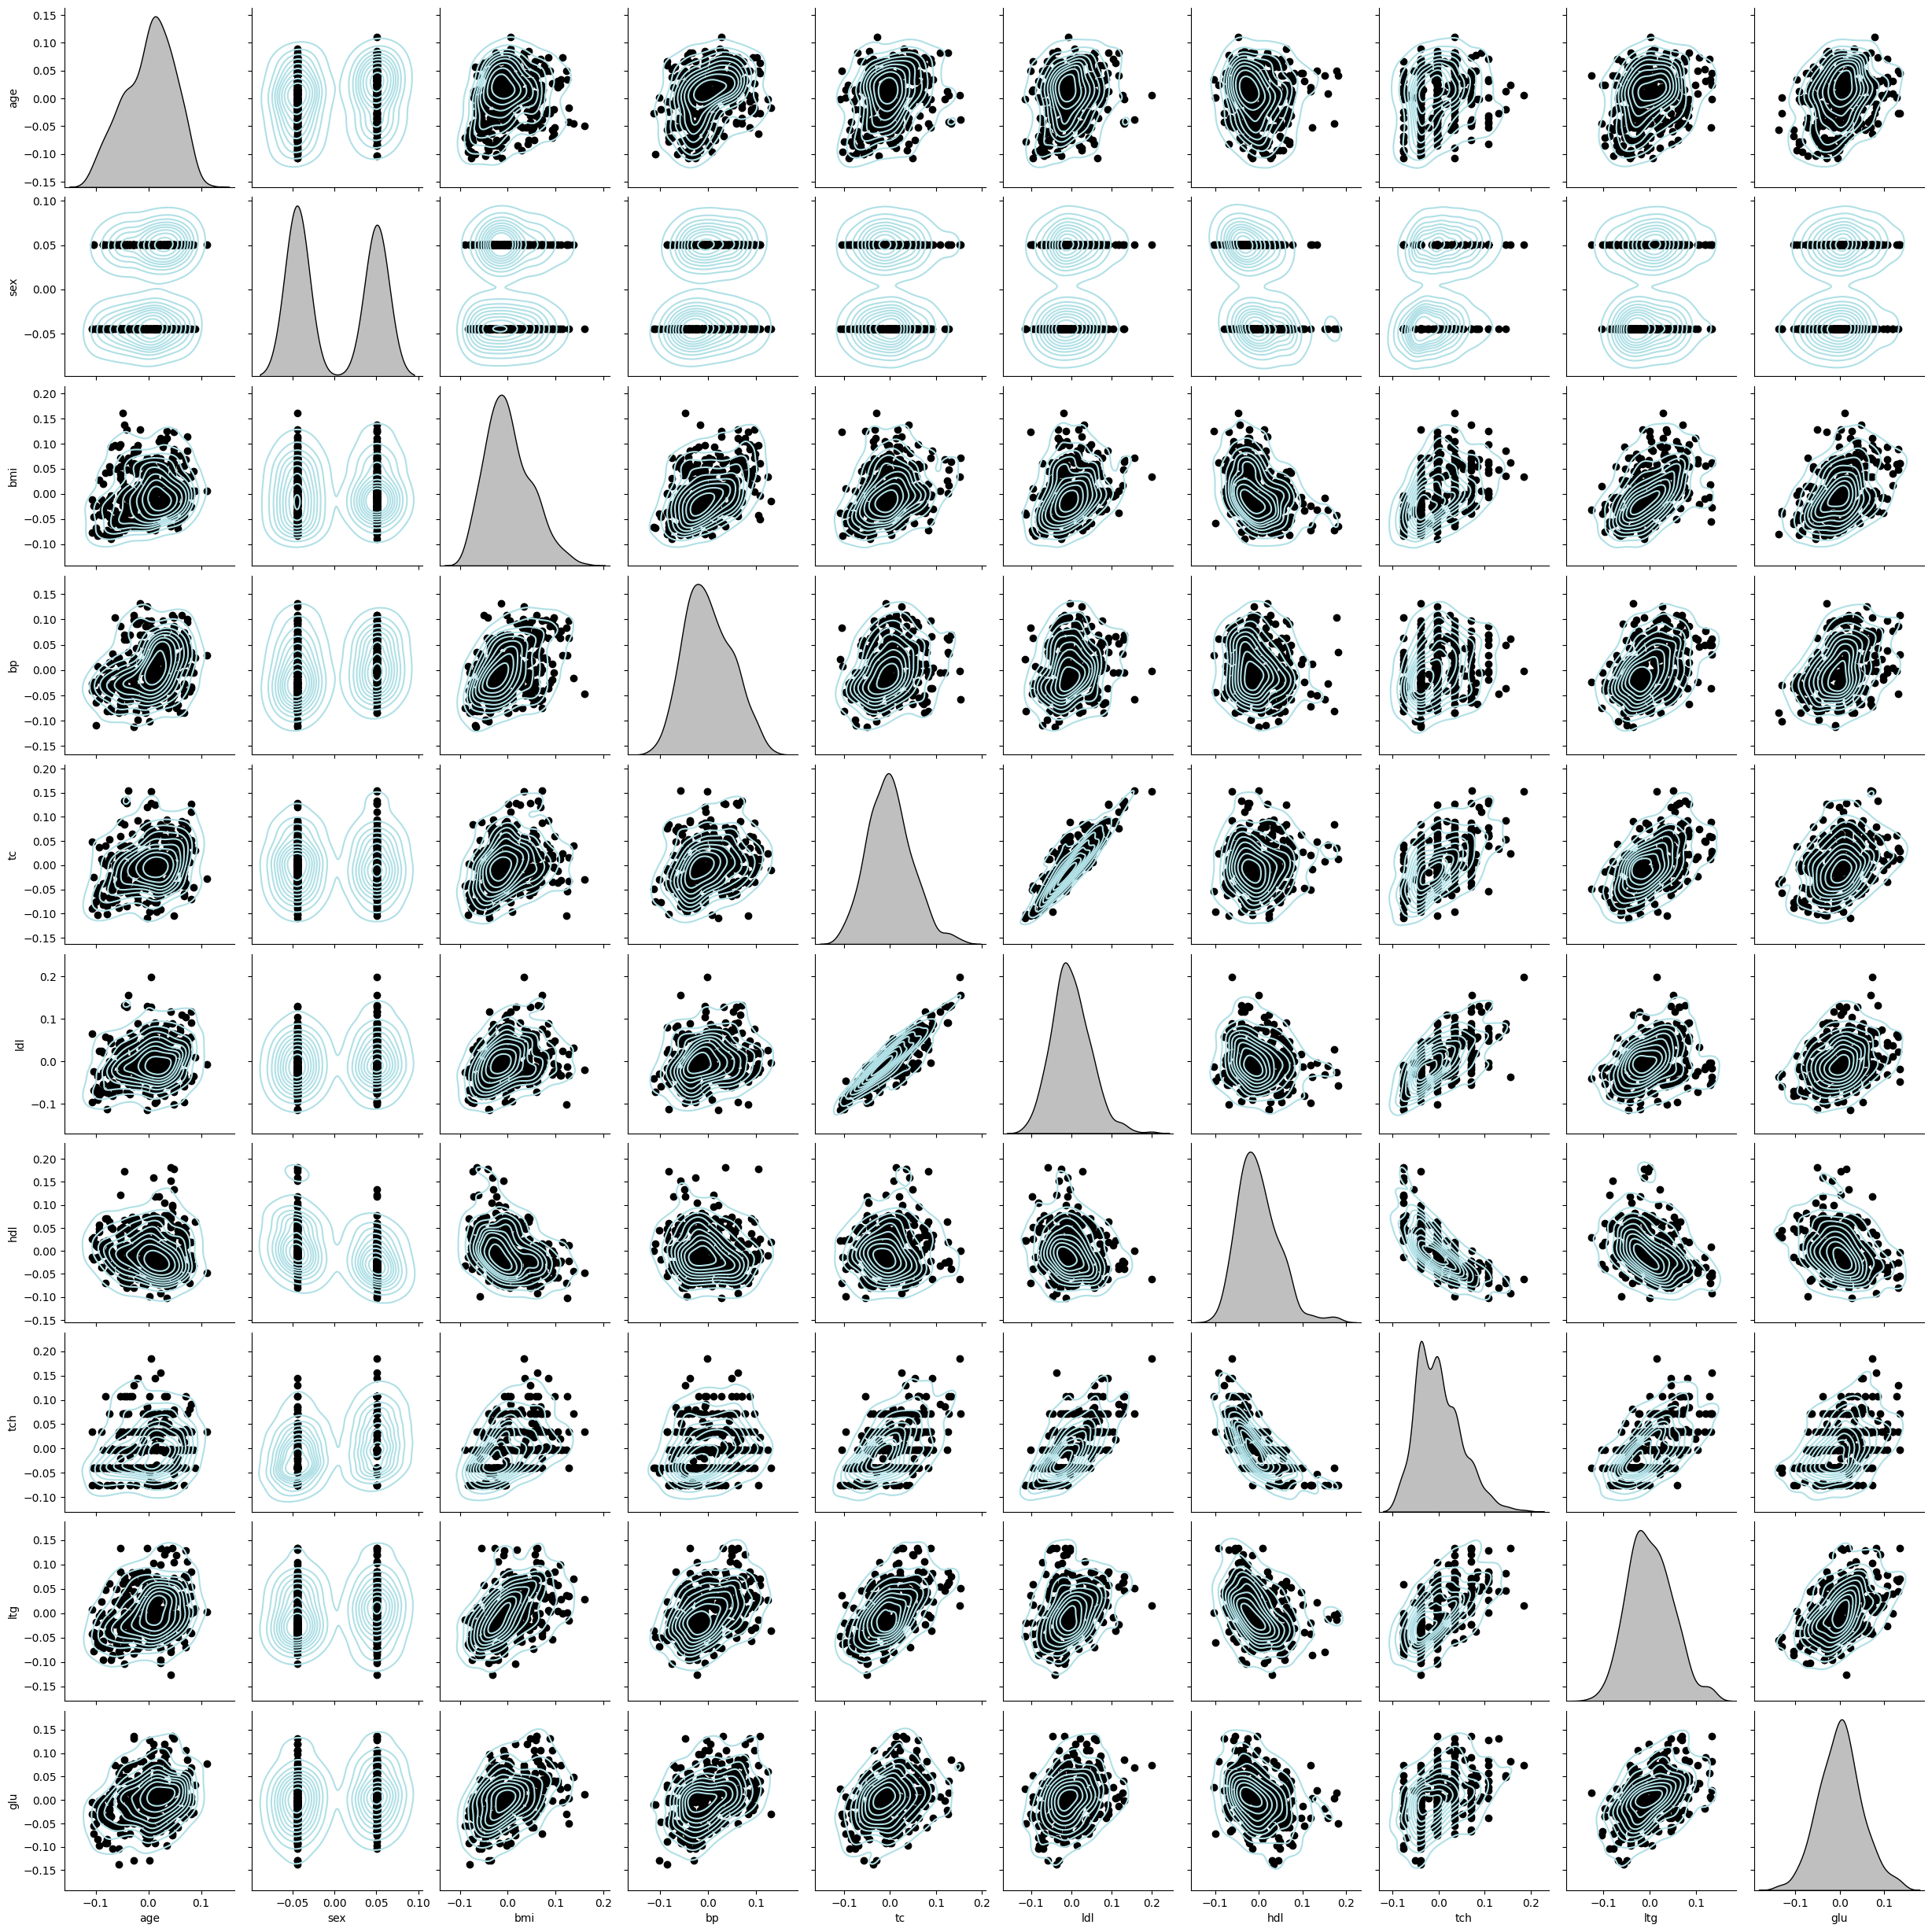

In [48]:
out = sns.pairplot(X_train, kind="kde", \
                   plot_kws={'color':[176/255,224/255,230/255]}, \
                   diag_kws={'color':'black'})
out.map_offdiag(plt.scatter, color = 'black')
plt.show()

Each scikit-learn dataset comes with a full description of the **Data Set Characteristics**, so let's bring some meaning to each of the attributes under investigation.

```
...
Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.
...
:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level
```

In the pair plot, we see one **binary categorical feature**, `sex`, that appears to skew the distributions of each of the other features, thus sex has a moderate corrleation with all features.

Also we see a strong corrleation between `tc` and `ldl` (total serum cholesterol and low-density lipoproteins) and a moderately strong negative correlation bewteen `tch` and `hdl` (total cholesterol / HDL and high-density lipoproteins).
These relationships are expected, given that the features are derived from overlapping biochemical measurements.

Additionally, we note a banding pattern in the `tch` correlation values across most features (with sex being a partial exception).
This may reflect characteristics of the measurement instrument used for lipoproteins or total cholesterol; such as range selection, resolution, or sensitivity thresholds.

"Logic is the beginning of wisdom, not the end." --Mr. Spock, Star Trek VI: The Undiscovered Country (1991)

Visualize the dataset using two principal components to see if the target variable can be separated.

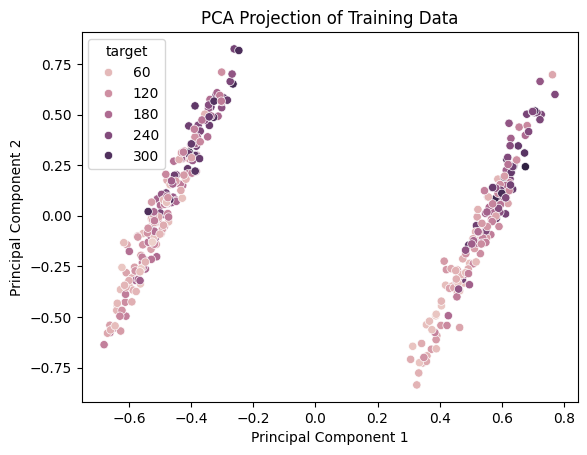

In [68]:
# Recall our dataset split: X_train, X_test, y_train, y_test

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# scale our training and test data
# note: scaled=True does not work as expected! ask about this!
scaler = MinMaxScaler(feature_range=(0, 1)) 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# fit PCA and transform our scaled data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)
# X_train_pca = pca.fit_transform(X_train) # lies! this data was not scaled on import!

# visualize first two PCs
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Training Data')
plt.show()

We observe a clear separation in the projection. As mentioned earlier, `sex` is a **binary categorical feature** that influences the distribution of nearly every other variable.
We can however clearly see that within each group, the target values (representing disease progression relative to baseline) tend to increase as both PC1 and PC2 increase.
Thus, the target variable can indeed be separated in the reduced feature space.

Now we can continue happily knowing that at least in this small space, the universe is understandable.

Note: That `load_diabetes(scaled=True) does not scale our data as expected,  MinMixScaler() must be used pre-PCA.  See EDA section for how we determined this in the Appendix.

### 4) Linear Regression

Perform linear regression using the training set to predict the target variable. Remember to add the intercept. Discuss the your fitting results, including R-squared value, coefficients, and p-values.<br>
**Note, scaling/normalizing the data is not necessary here.**<br>
One feature, sex, is a **categorical**. For now, we want to treat this feature like all the other features, but what would you need to do in order to  represent this feature numerically?

In [67]:
#X_train_pca[:, 0], X_train_pca[:, 1]
np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), np.min(X_train_pca[:, 1]), np.max(X_train_pca[:, 1])
# good, a range between -1 and 1 is what we expected

(np.float64(-0.6805493317495058),
 np.float64(0.7714450929335601),
 np.float64(-0.8356443534482595),
 np.float64(0.8241089824373572))

In [69]:
X_train.columns

Index(['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'], dtype='object')

In [81]:
# let's do this just like the example walk through
# we can play around later in the appendix
# for now, let's go easy on the grader. ;-)

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ols.fit() expects a DataFrame
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# add target to DataFrame for ols equation
X_train_df['target'] = y_train

# statsmodels.formula.api.ols automagically add the intercept
eq = 'target ~ ' + '+'.join(X_train_df.columns[:-1])
print(eq)

model = ols(eq, data = X_train_df).fit()

print(model.summary())

target ~ age+sex+bmi+bp+tc+ldl+hdl+tch+ltg+glu
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     38.25
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           5.41e-50
Time:                        16:37:50   Log-Likelihood:                -1906.1
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     342   BIC:                             3877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

In [83]:
table    = sm.stats.anova_lm(model, typ = 1)
display(table)

df        sum_sq        mean_sq           F        PR(>F)
age         1.0  8.283022e+04   82830.219398   27.975498  2.197514e-07
sex         1.0  1.553938e+03    1553.938330    0.524835  4.692818e-01
bmi         1.0  7.177757e+05  717775.681376  242.425199  1.075817e-41
bp          1.0  9.941014e+04   99410.139785   33.575285  1.556669e-08
tc          1.0  1.098450e+01      10.984499    0.003710  9.514669e-01
ldl         1.0  2.656241e+03    2656.241405    0.897132  3.442205e-01
hdl         1.0  1.764831e+05  176483.140983   59.606311  1.289650e-13
tch         1.0  4.688126e+03    4688.126117    1.583391  2.091312e-01
ltg         1.0  4.566141e+04   45661.411324   15.421917  1.040169e-04
glu         1.0  1.300570e+03    1300.570265    0.439261  5.079257e-01
Residual  342.0  1.012598e+06    2960.812997         NaN           NaN

*Remember to add the intercept.*

We found that statsmodels.formula.api.ols automagically added the intercept for us.

*Discuss the your fitting results, including R-squared value, coefficients, and p-values.*

The $R^2$ value of 0.528 says that our model explains 53% of the variance in the target varible.
The adjusted $R^2$ value of 0.514 confirms that the model generalizes well for unseen data.

Several features show strong individual contributions:
 - `sex` has a large negative coefficient and is highly significant.
 - `bmi`, `bp`, and `ltg` all have large positive coefficients and low p-values, suggesting strong association with the target (disease progression).
 - `tc` has a significant negative coefficient, which maybe due to multicollinearity.

*Note, scaling/normalizing the data is not necessary here.*

We tried scaling and indeed this did not work well at all.  Think about this!

*One feature, sex, is a categorical. For now, we want to treat this feature like all the other features, but what would you need to do in order to represent this feature numerically?*

We might use binary encoding if there are only two categories, or one-hot encoding if there are more.
However, when using statsmodels with formula syntax, the Patsy interpreter can automatically convert categorical variables to dummy variables; ie. `eq = 'target ~ C(sex) + age + bmi + bp + ...'`.

**Going deeper:**

ANOVA results align with the regression summary; `bmi`, `bp`, and `hdl` are consistently strong predictors of disease progression.

`bmi` has the largest sum of squares and an extremely low p-value (~ 1e-41), thus indicates it explains a lot of the variance.

`bp` and `hdl` also show strong effects, with high F-statistics and p-values well below 0.001.

`ltg` (possiblity log of serum triglycerides) is moderately strong, with a p-value around 0.0001.

Recall Attribute Information:
 - age:     age in years
 - sex:     -0.04464164/0.05068012 (not explicity mapped to male or female)
 - bmi:     body mass index
 - bp:      average blood pressure
 - tc:      total serum cholesterol
 - ldl:     low-density lipoproteins
 - hdl:     high-density lipoproteins
 - tch:     total cholesterol / HDL
 - ltg:     possibly log of serum triglycerides level
 - glu:     blood sugar level

Plot the residuals of the model. Discuss whether the residuals appear to be normally distributed.

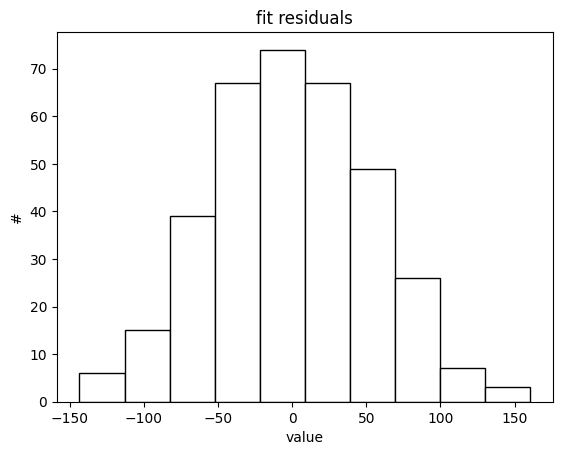

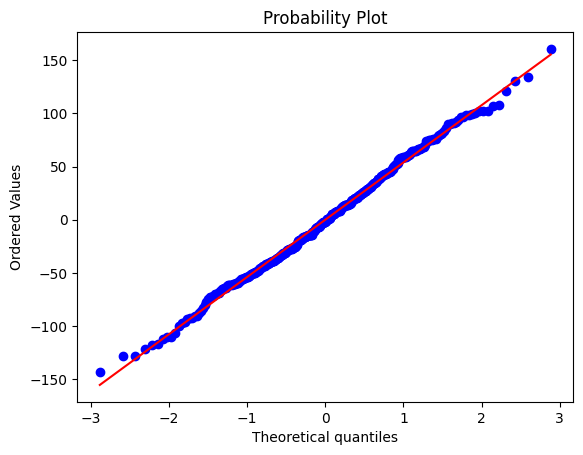

In [86]:
#for QQ plot
import pylab 
import scipy.stats as stats

residuals = model.resid
plt.hist(residuals, color = 'w', edgecolor = 'black')
plt.title('fit residuals')
plt.ylabel('#')
plt.xlabel('value')
plt.show()

stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

*Discuss whether the residuals appear to be normally distributed.*

That looks like a Gaussian distribution and the probablity plot further confirms this. 

Plot the predictions against the true values for both training and testing sets. Calculate and report the Mean Absolute Error (MAE) for both sets. Discuss the model's performance and any potential overfitting or underfitting issues.

Train MAE: 43.48
Test MAE: 42.79


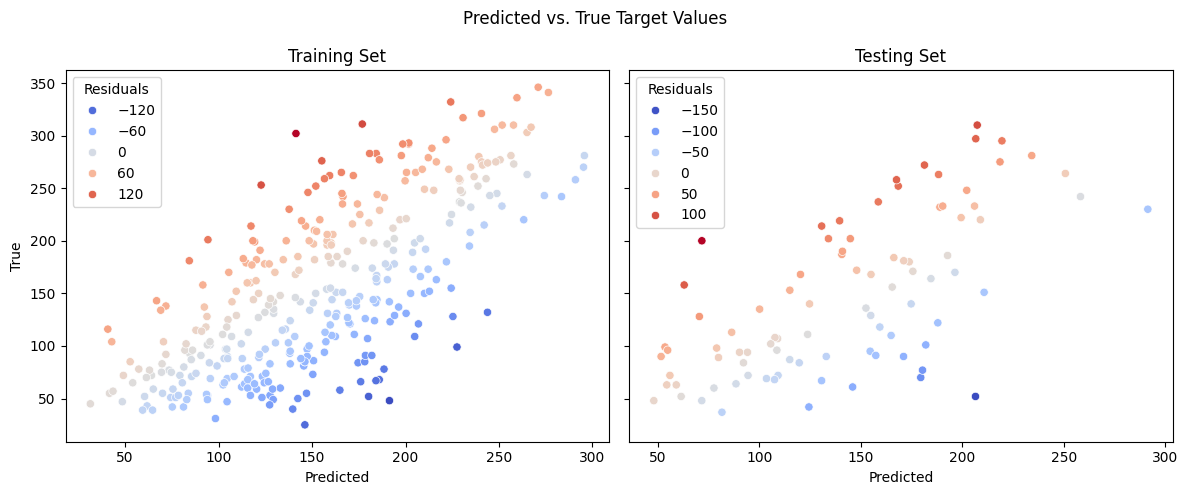

In [98]:
from sklearn.metrics import mean_absolute_error

# make predictions
y_train_pred = model.predict(X_train_df)
y_test_pred = model.predict(X_test_df)

# compute residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# mean absolute error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")

# plot predictions vs true values
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.scatterplot(x=y_train_pred, y=y_train, ax=axes[0], hue=residuals_train, palette='coolwarm')
axes[0].set_title("Training Set")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].legend(title='Residuals')

sns.scatterplot(x=y_test_pred, y=y_test, ax=axes[1], hue=residuals_test, palette='coolwarm')
axes[1].set_title("Testing Set")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].legend(title='Residuals')

plt.suptitle("Predicted vs. True Target Values")
plt.tight_layout()
plt.show()

*Discuss the model's performance and any potential overfitting or underfitting issues.*

Recall:

```
Train MAE: 43.48
Test MAE: 42.79
```
These values are very close, which suggests that the model generalizes well to unseen data. There is no clear evidence of overfitting.

The scatter plot of predicted vs true values shows that most points fall along a diagonal line, indicating that the model captures the overall trend in the data.
However, the spread around this line and the relatively high MAE (40s) suggest that predictions still deviate substantially from the true values.

This points to underfitting, which may indicate that the underlying relationships are nonlinear or involve complex interactions that a linear model cannot capture.
The current model is likely too simple to represent the full structure of the data.

Further improvements may require nonlinear modeling, interaction terms, or regularization to better capture the complexity of disease progression.

### 5) Logistic Regression

Classify the target variable into two classes: above and below 150.

In [99]:
y_train_cat = (y_train > 150).astype(int)
y_test_cat = (y_test > 150).astype(int)

Use Gaussian Naive Bayes to classify the data. Report the accuracy and confusion matrix. Discuss the model's performance and any potential limitations.

In [ ]:
######## Fill in the code below ########

########################################

> your answer here

Use logistic regression to classify the data. Report the accuracy and confusion matrix. Discuss the model's performance and fitting results.

In [ ]:
######## Fill in the code below ########

########################################

> your answer here

For each class, plot the histogram of the predicted probabilities. Discuss how well the model separates the two classes.

In [ ]:
######## Fill in the code below ########

########################################

> your answer here

# Appendix

## EDA

see also: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html

In [58]:
import sklearn
print(sklearn.__version__)

1.7.1


In [59]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes(as_frame=True, scaled=True) # scaled as no effect!!

In [60]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

So we meet again Professor Hastie.  ;-)

In [61]:
import numpy as np

np.unique(diabetes.target)

array([ 25.,  31.,  37.,  39.,  40.,  42.,  43.,  44.,  45.,  47.,  48.,
        49.,  50.,  51.,  52.,  53.,  54.,  55.,  57.,  58.,  59.,  60.,
        61.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  77.,  78.,  79.,  80.,  81.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
        97.,  98.,  99., 100., 101., 102., 103., 104., 107., 108., 109.,
       110., 111., 113., 114., 115., 116., 118., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 131., 132., 134., 135., 136.,
       137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147.,
       148., 150., 151., 152., 153., 154., 155., 156., 158., 160., 161.,
       162., 163., 164., 166., 167., 168., 170., 171., 172., 173., 174.,
       175., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 189., 190., 191., 192., 195., 196., 197., 198., 199., 200.,
       201., 202., 206., 208., 209., 210., 212., 21

In [62]:
np.unique(diabetes.data['sex'])

array([-0.04464164,  0.05068012])